# Trabajo de Decisiones de financiación
### Por Antonio Álvarez, Guillermo López y Fabrizio Zeballos

En este notebook, se aborda el mercado de futuros del oro con un enfoque centrado en la eficiencia. Este análisis se enfoca en evaluar hasta qué punto este mercado refleja la información pasada y actual, así como en qué medida incorpora toda la información disponible, incluyendo eventos futuros y datos privados. A través de este examen exhaustivo, se busca proporcionar una comprensión completa de la eficiencia de este mercado vital en la economía global y su capacidad para informar decisiones de inversión y financieras.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import zscore
from scipy.stats import wilcoxon
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime

In [ ]:
df = pd.read_csv('/content/Gold_data.csv')

# Preprocesamiento

En esta sección se aborda la limpieza y organización de la información recopilada en la base de datos. Con ello se garantiza que en la sección de análisis se minimicen errores y que estén en el formato adecuado para su uso. Se comienza por hacer obtener una visión general del dataset en su conjunto.

In [ ]:
df.sample(10)

,date,open,high,low,close,volume
4631,2019-02-22,1324.199951,1331.300049,1321.000000,1329.199951,718
4304,2017-10-31,1273.099976,1274.599976,1266.099976,1267.000000,235
990,2004-08-23,411.299988,411.799988,409.700012,410.500000,18
2839,2012-01-03,1568.900024,1604.300049,1566.000000,1599.699951,229
1754,2007-09-13,706.900024,707.400024,706.900024,709.500000,19
2116,2009-02-20,974.000000,1004.900024,971.599976,1001.799988,219
5636,2023-02-17,1827.400024,1842.199951,1818.400024,1840.400024,35
4552,2018-10-26,1234.300049,1234.800049,1232.500000,1232.500000,20
51,2000-11-10,264.500000,264.500000,264.500000,264.500000,0
4056,2016-11-03,1296.400024,1303.099976,1287.300049,1302.099976,73


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5785 entries, 0 to 5784
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    5785 non-null   object 
 1   open    5785 non-null   float64
 2   high    5785 non-null   float64
 3   low     5785 non-null   float64
 4   close   5785 non-null   float64
 5   volume  5785 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 271.3+ KB


Al analizar los tipos de datos de cada columna, se aprecia que el tipo de la columna de fechas "date" es object. Se procede a convertir el tipo de la columnas a datetime de pandas.

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5785 entries, 0 to 5784
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5785 non-null   datetime64[ns]
 1   open    5785 non-null   float64       
 2   high    5785 non-null   float64       
 3   low     5785 non-null   float64       
 4   close   5785 non-null   float64       
 5   volume  5785 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 271.3 KB


Finalmente, se procede a establecer la columna de fecha como índice del dataframe.

In [ ]:
 #df = df.set_index('date')

### Procesamiento de nulos



In [ ]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

No existen nulos en el dataset, por lo que no es necesario aplicar técnicas de manejo de datos nulos.

### Variables Categóricas y Valores Atípicos

No existen variables categóricas en el dataset, por lo que no es necesario manejar este tipo de valores. Pasamos al análisis de valores atípicos.



In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns

aux = df[num_cols]
aux = aux.apply(zscore)
aux.min(), aux.max()

(open     -1.604623
 high     -1.603957
 low      -1.603186
 close    -1.604440
 volume   -0.175710
 dtype: float64,
 open       1.819092
 high       1.833467
 low        1.815073
 close      1.815479
 volume    15.642193
 dtype: float64)

Al estandarizar las variables en busca de valores atípicos, destaca enormemente la variable de volumen, Teniendo como máximo cerca de 16 desviaciones de la media. Se procede a analizarla más detenidamente.

Número de observaciones de la columna volume con valor 0: 413
Porcentaje de observaciones con valor 0 en volumen: 7.139152981849612 %


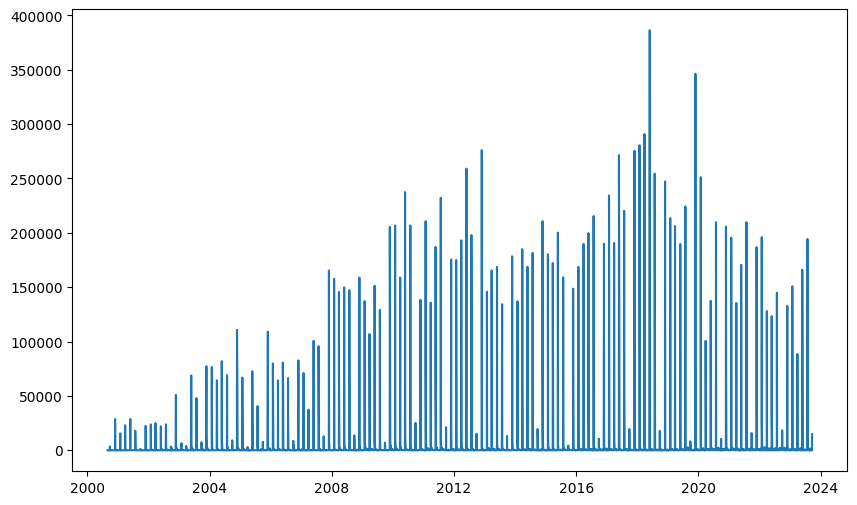

In [ ]:
mask = df['volume'] == 0
print('Número de observaciones de la columna volume con valor 0:', len(df[mask]))
print('Porcentaje de observaciones con valor 0 en volumen:', (len(df[mask])/len(df['volume']))*100, '%')

date = df['date']
volume = df['volume']

fig,ax = plt.subplots(figsize=(10,6))
ax.plot(date,volume);

Al graficar el volumen de operaciones en el tiempo, se obtiene información acerca de esta gran variabilidad. Existe un gran número de días en los que el volumen de operaciones es 0.

Media del volumen en futuros del oro:  4291.521866897147
Máximo del volumen en futuros del oro:  386334


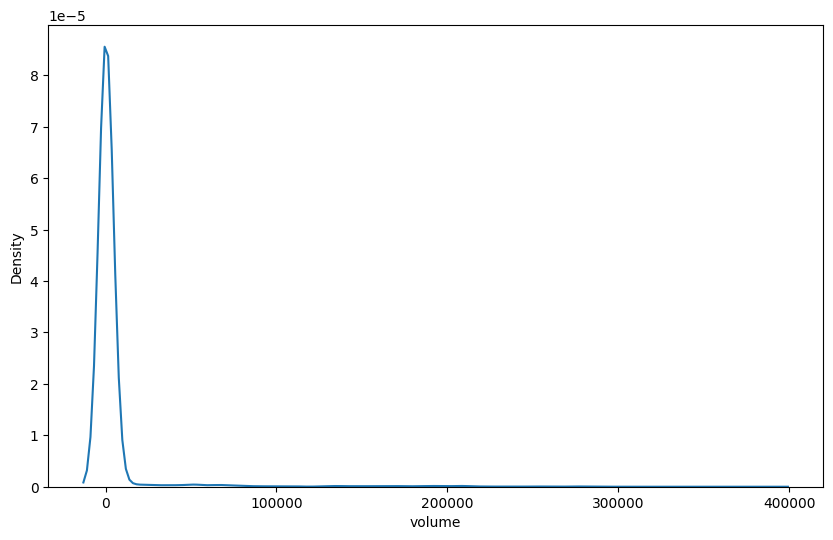

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(df['volume'])
print('Media del volumen en futuros del oro: ', df['volume'].mean())
print('Máximo del volumen en futuros del oro: ', df['volume'].max())


Se constata que existen valores muy alejados de la media, siendo el más extremo 386334, 90 veces más grande que la media. Esto se puede visualizar al graficar la distribución utilizando la estimación de densidad de Kernel.

Se ha decidido dejar los valores atípicos en el dataframe, ya que puede pueden ser de gran interés para el objeto de estudio de este notebook.

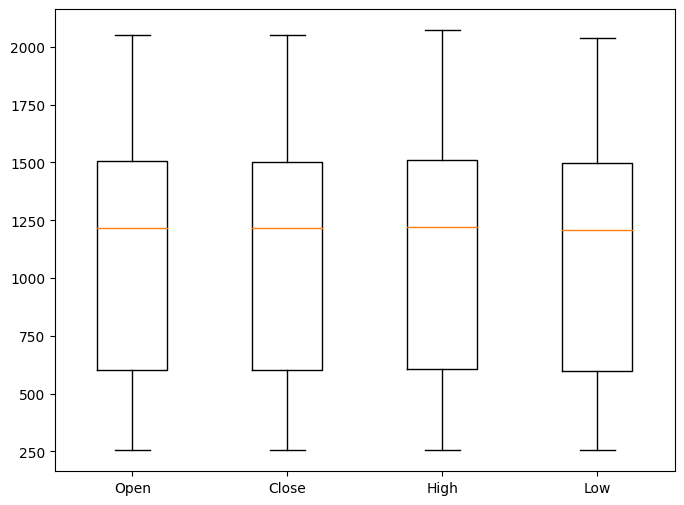

In [ ]:
plt.figure(figsize=(8,6))
plt.boxplot(
    [
      df['open'],
      df['close'],
      df['high'],
      df['low']
    ],
    labels=['Open','Close','High', 'Low']
    )

plt.title('')
plt.show()

Al analizar el resto de variables, no se encuentra otra con valores atípicos.

In [ ]:

def return_list(l):
    ret = [((b-a)/a)*100 for a,b in zip(l[::1], l[1::1])]
    return ret

# Análisis

### Análisis de Correlación de series Temporales

In [ ]:
# Carga de dataframes
df_silver = pd.read_csv('/content/Silver_data.csv')
df_platinum = pd.read_csv('/content/Platinum_data.csv')
df_palladium = pd.read_csv('/content/Palladium_data.csv')
df_copper = pd.read_csv('/content/Copper_data.csv')

# Conversión de tipos de fecha a datetime
df_silver['date'] = pd.to_datetime(df_silver['date'])
df_platinum['date'] = pd.to_datetime(df_platinum['date'])
df_palladium['date'] = pd.to_datetime(df_palladium['date'])
df_copper['date'] = pd.to_datetime(df_copper['date'])


Correlation between gold and silver:  0.8711401981094682
Correlation between gold and platinum:  0.3665596036557395
Correlation between gold and palladium:  0.6560735094792172
Correlation between gold and copper:  0.8020629093078866


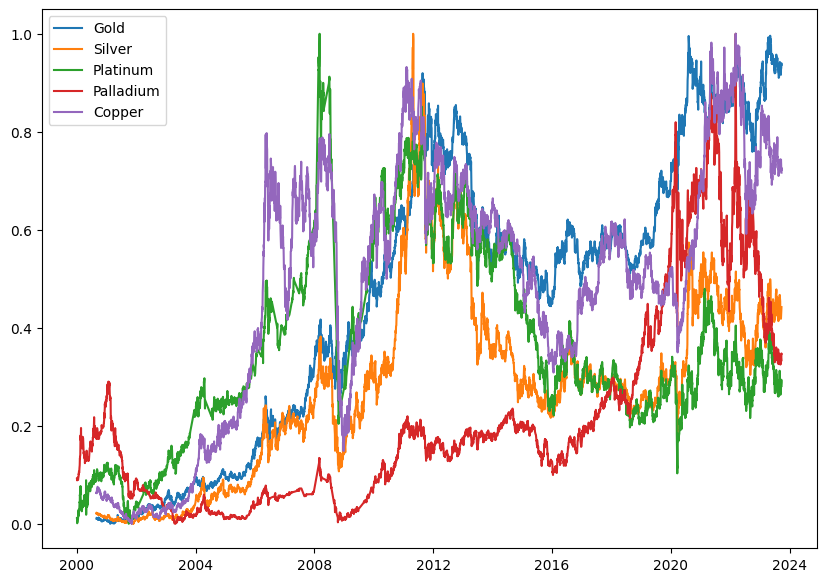

In [ ]:

scale = MinMaxScaler()
aux_gold = scale.fit_transform(df[['open']])
aux_silver = scale.fit_transform(df_silver[['open']])
aux_platinum = scale.fit_transform(df_platinum[['open']])
aux_palladium = scale.fit_transform(df_palladium[['open']])
aux_copper = scale.fit_transform(df_copper[['open']])

corr_gold_silver = df['open'].corr(df_silver['open'])
corr_gold_platinum = df['open'].corr(df_platinum['open'])
corr_gold_palladium = df['open'].corr(df_palladium['open'])
corr_gold_copper = df['open'].corr(df_copper['open'])

print('Correlation between gold and silver: ', corr_gold_silver)
print('Correlation between gold and platinum: ', corr_gold_platinum)
print('Correlation between gold and palladium: ', corr_gold_palladium)
print('Correlation between gold and copper: ', corr_gold_copper)

plt.figure(figsize=(10,7))
plt.plot(df['date'], aux_gold, label='Gold')
plt.plot(df_silver['date'], aux_silver, label='Silver')
plt.plot(df_platinum['date'], aux_platinum, label='Platinum')
plt.plot(df_palladium['date'], aux_palladium, label='Palladium')
plt.plot(df_copper['date'], aux_copper, label='Copper')
plt.legend()
plt.show();

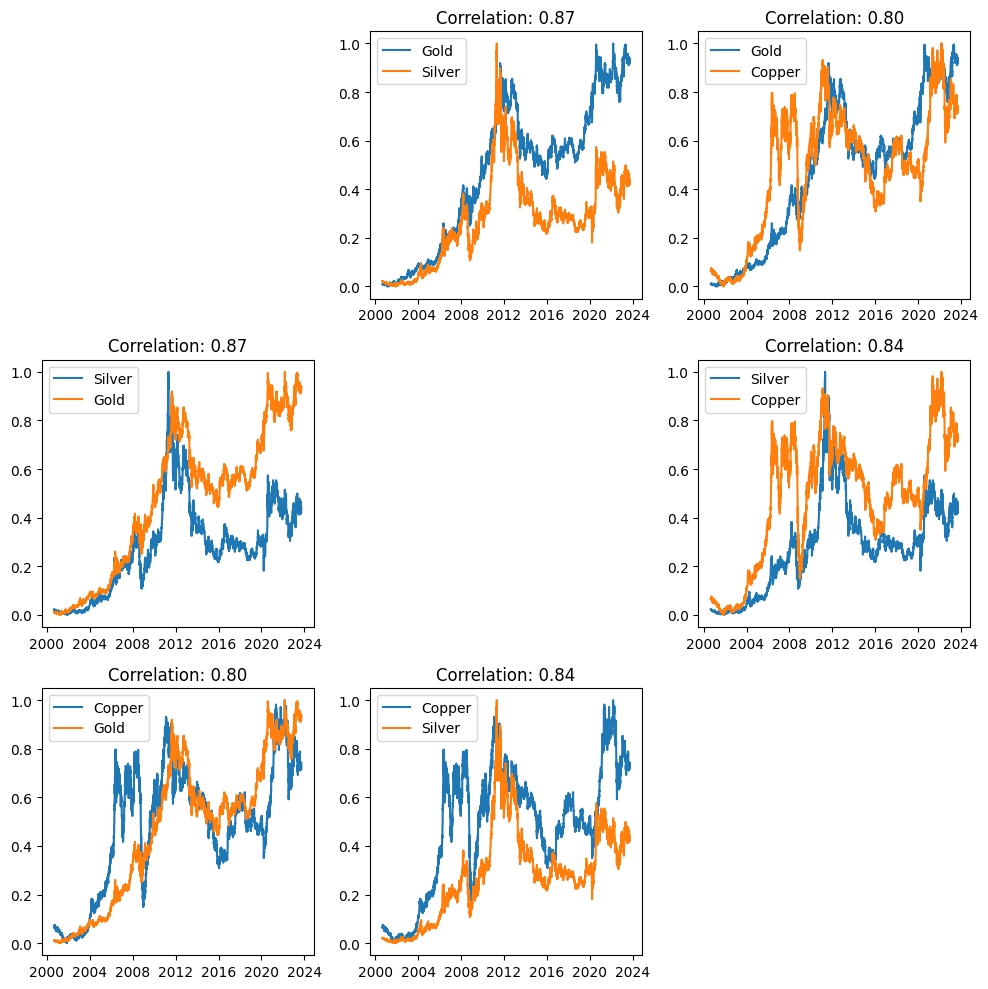

In [ ]:
metal_names = ['Gold', 'Silver', 'Copper']
metal_dataframes = [df, df_silver, df_copper]

# Tantos subplots como longitud de las listas de metales.
fig, axs = plt.subplots(len(metal_names), len(metal_names), figsize=(10, 10))

for i in range(len(metal_names)):
    for j in range(len(metal_names)):
        if i == j:
            axs[i, j].axis('off')  # Desactivar gráficos en la diagonal principal
        else:
            scale = MinMaxScaler()
            aux_i = scale.fit_transform(metal_dataframes[i][['open']])
            aux_j = scale.fit_transform(metal_dataframes[j][['open']])

            corr_ij = metal_dataframes[i]['open'].corr(metal_dataframes[j]['open'])
            axs[i, j].plot(metal_dataframes[i]['date'], aux_i, label=metal_names[i])
            axs[i, j].plot(metal_dataframes[j]['date'], aux_j, label=metal_names[j])
            axs[i, j].set_title(f'Correlation: {corr_ij:.2f}')
            axs[i, j].legend()

plt.tight_layout()
plt.show()


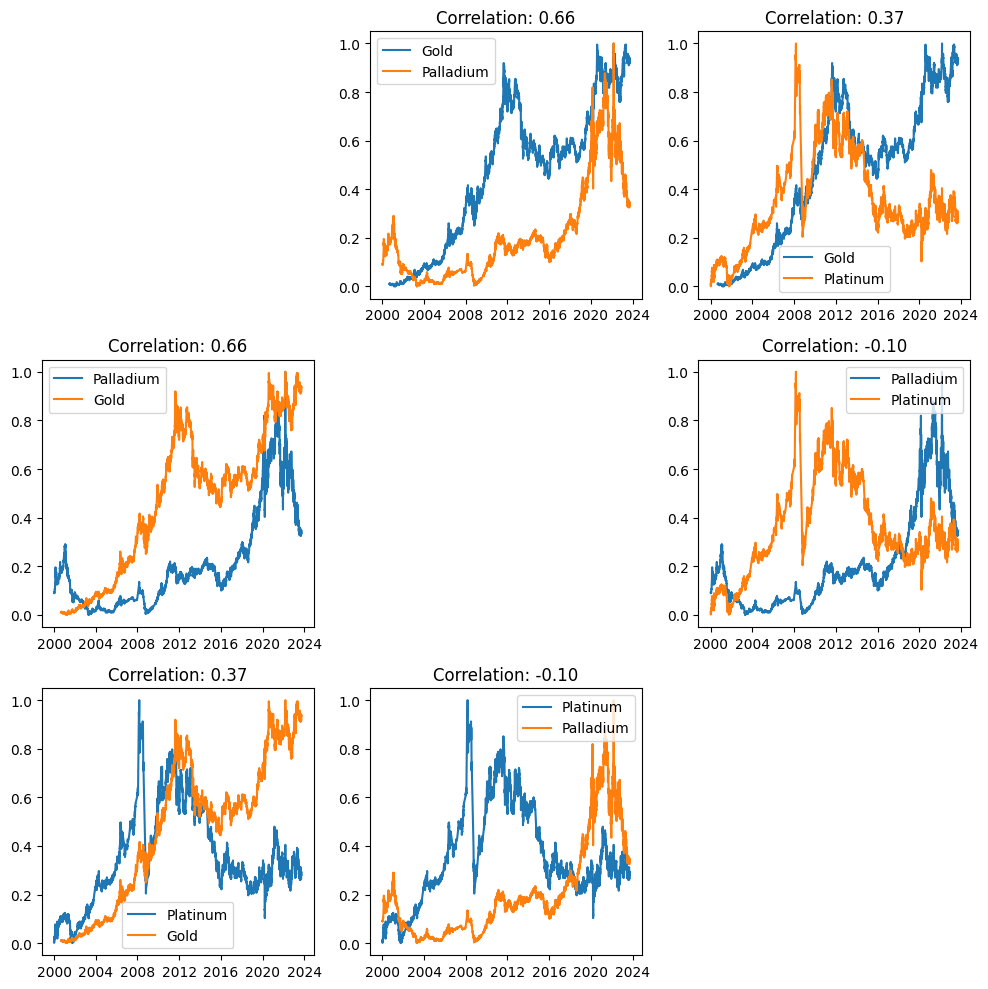

In [ ]:
metal_names = ['Gold', 'Palladium', 'Platinum']
metal_dataframes = [df, df_palladium, df_platinum]

# Tantos subplots como longitud de las listas de metales.
fig, axs = plt.subplots(len(metal_names), len(metal_names), figsize=(10, 10))

for i in range(len(metal_names)):
    for j in range(len(metal_names)):
        if i == j:
            axs[i, j].axis('off')  # Desactivar gráficos en la diagonal principal
        else:
            scale = MinMaxScaler()
            aux_i = scale.fit_transform(metal_dataframes[i][['open']])
            aux_j = scale.fit_transform(metal_dataframes[j][['open']])

            corr_ij = metal_dataframes[i]['open'].corr(metal_dataframes[j]['open'])
            axs[i, j].plot(metal_dataframes[i]['date'], aux_i, label=metal_names[i])
            axs[i, j].plot(metal_dataframes[j]['date'], aux_j, label=metal_names[j])
            axs[i, j].set_title(f'Correlation: {corr_ij:.2f}')
            axs[i, j].legend()

plt.tight_layout()
plt.show()

In [ ]:
adf = adfuller(df['open'])

print('Estadístico ADF: %f' % adf[0])
print('p-value: %f' % adf[1])
print('Critical Values:')
print('\t1%: ', adf[4]['1%'])
print('\t5%: ', adf[4]['5%'])
print('\t10%: ', adf[4]['10%'])

Estadístico ADF: -0.853889
p-value: 0.802778
Critical Values:
	1%:  -3.4314830463374872
	5%:  -2.8620406987336584
	10%:  -2.5670365200019343


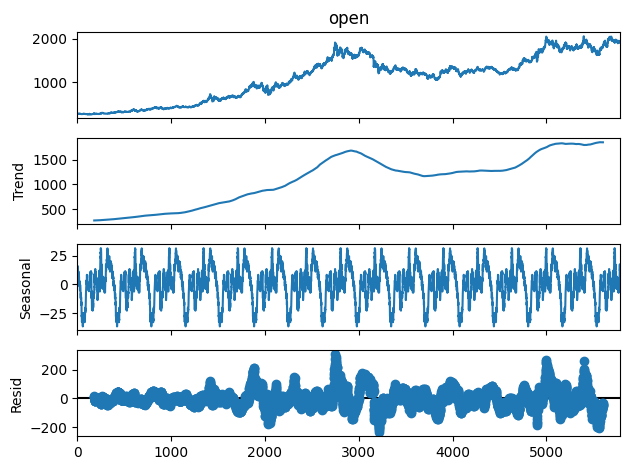

In [ ]:
res = seasonal_decompose(df['open'], period=365)
res.plot()
plt.show();

### Análisis de correlación con el BTC

In [ ]:
bitcoin_symbol = "BTC-USD"
start_date = "2015-01-01"
end_date = "2021-12-31"

df_btc = yf.download(bitcoin_symbol, start=start_date, end=end_date)
df_btc = df_btc.reset_index(drop=False)
df_btc.head(5)

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


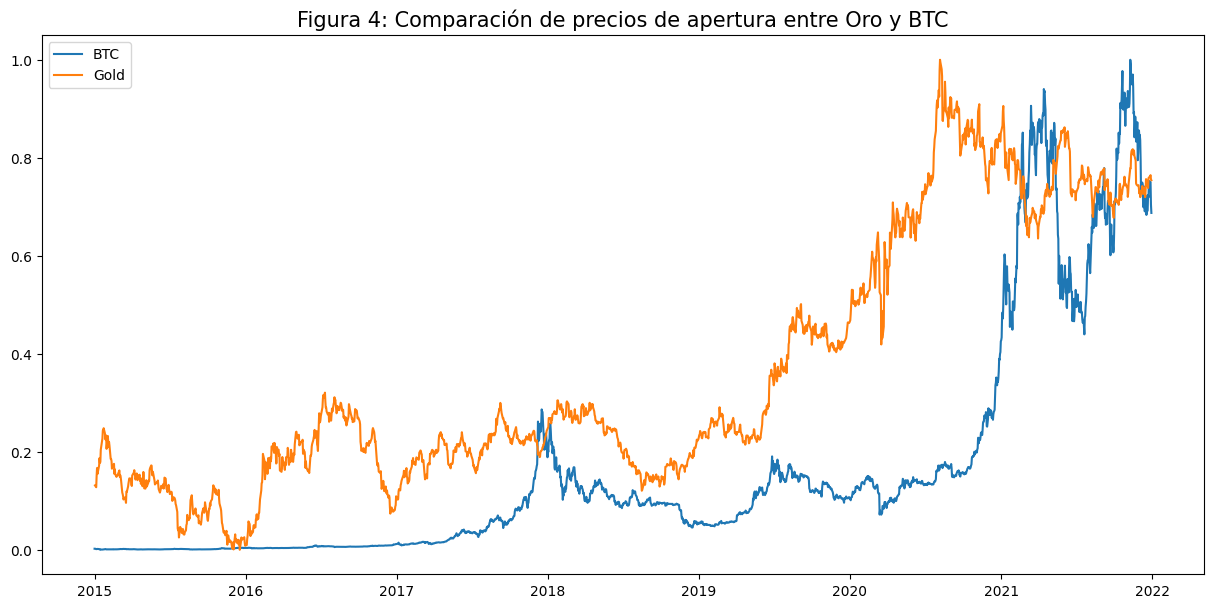

0      2015-01-01
2      2015-01-03
3      2015-01-04
9      2015-01-10
10     2015-01-11
          ...    
2543   2021-12-18
2544   2021-12-19
2549   2021-12-24
2550   2021-12-25
2551   2021-12-26
Name: Date, Length: 797, dtype: datetime64[ns]
Correlation between gold and Bitcoin:  nan


In [ ]:
# plot
date_min = df_btc['Date'].min()
date_max = df_btc['Date'].max()
mask = (df['date'] >= date_min) & (df['date'] <= date_max)
gold_sliced = df[mask]

aux_btc = scale.fit_transform(df_btc[['Open']])
aux_gold = scale.fit_transform(gold_sliced[['open']])


plt.figure(figsize=(15,7))
plt.plot(df_btc['Date'],aux_btc, label='BTC')
plt.plot(gold_sliced['date'], aux_gold, label='Gold')
plt.legend()
plt.title('Figura 4: Comparación de precios de apertura entre Oro y BTC', size = 15)
plt.show()

# Correlation

values = ~df_btc['Date'].isin(gold_sliced['date'])
print(df_btc[values]['Date']) # Todas las fechas que no hay en el dataframe del oro

corr_gold_btc = gold_sliced['open'].corr(df_btc['Open'])
print('Correlation between gold and Bitcoin: ', corr_gold_btc) # no se puede hacer correlación porque faltan 750 filas con fechas entre 2014 y 2022


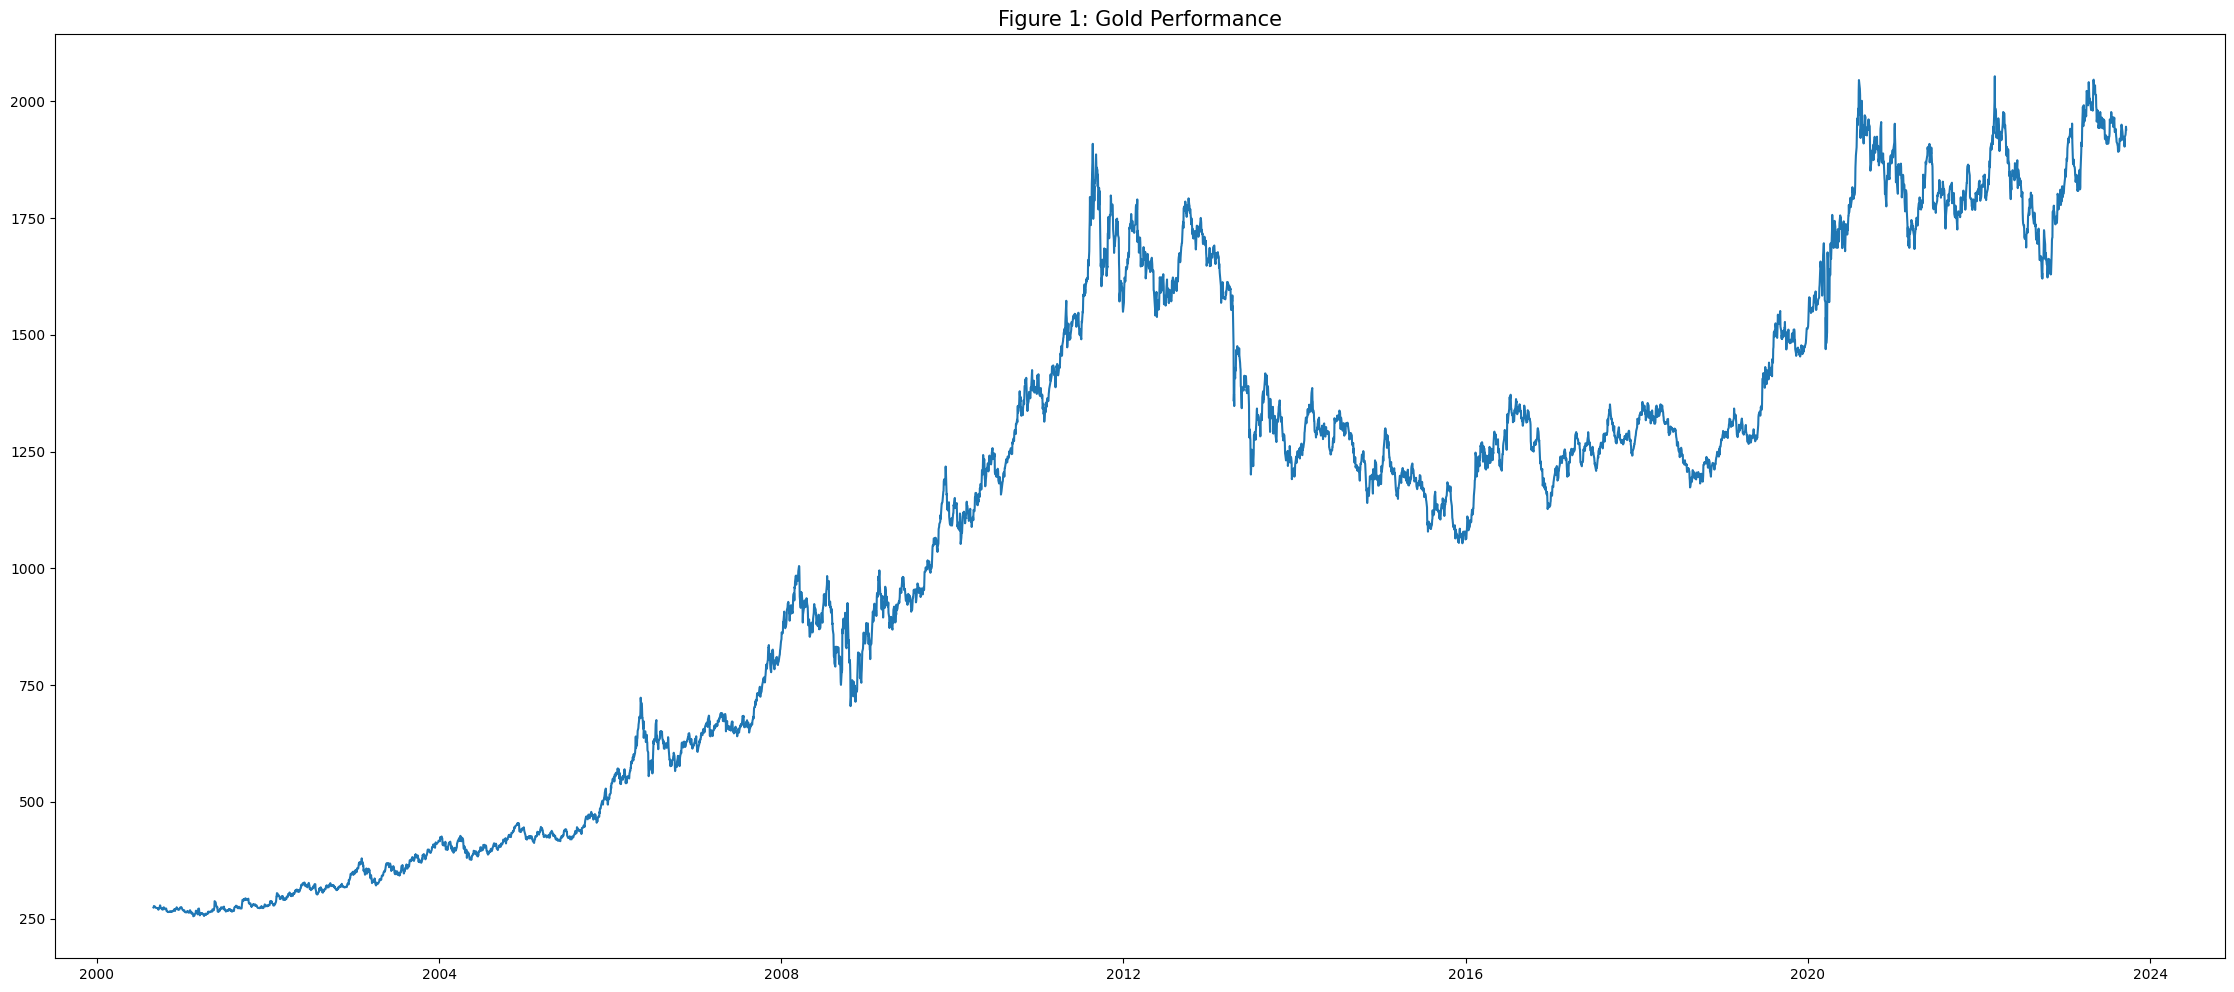

In [ ]:
plt.figure(figsize=(28,12))
plt.plot(df['date'], df['open'])
plt.title('Figure 1: Gold Performance', size = 15)
plt.show();

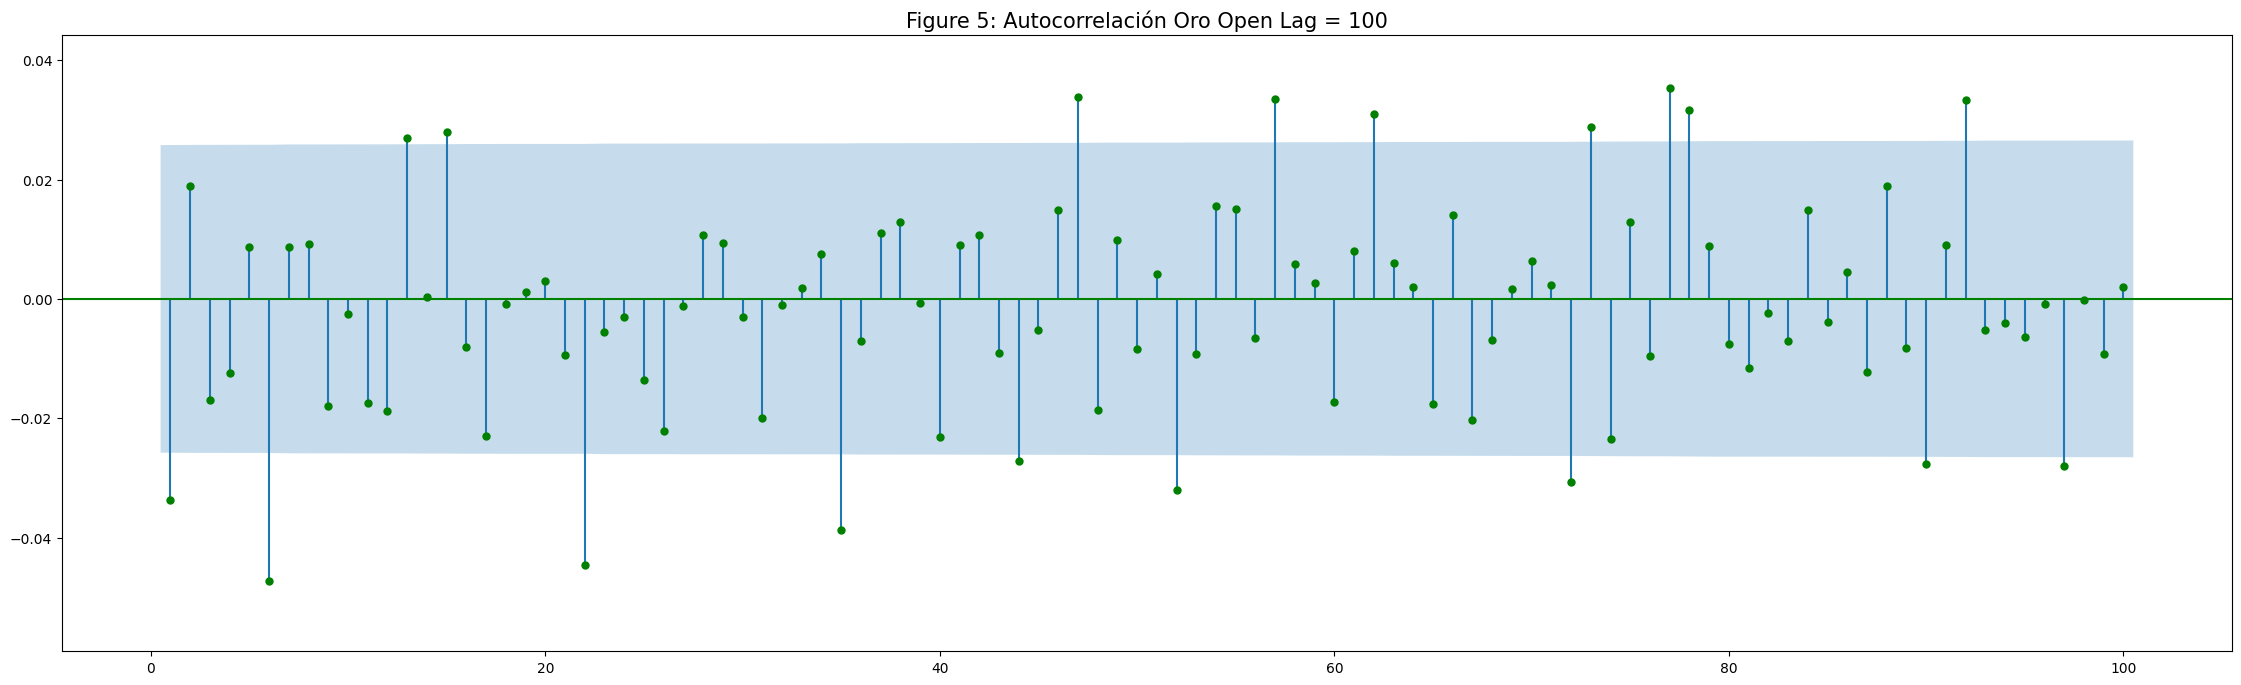

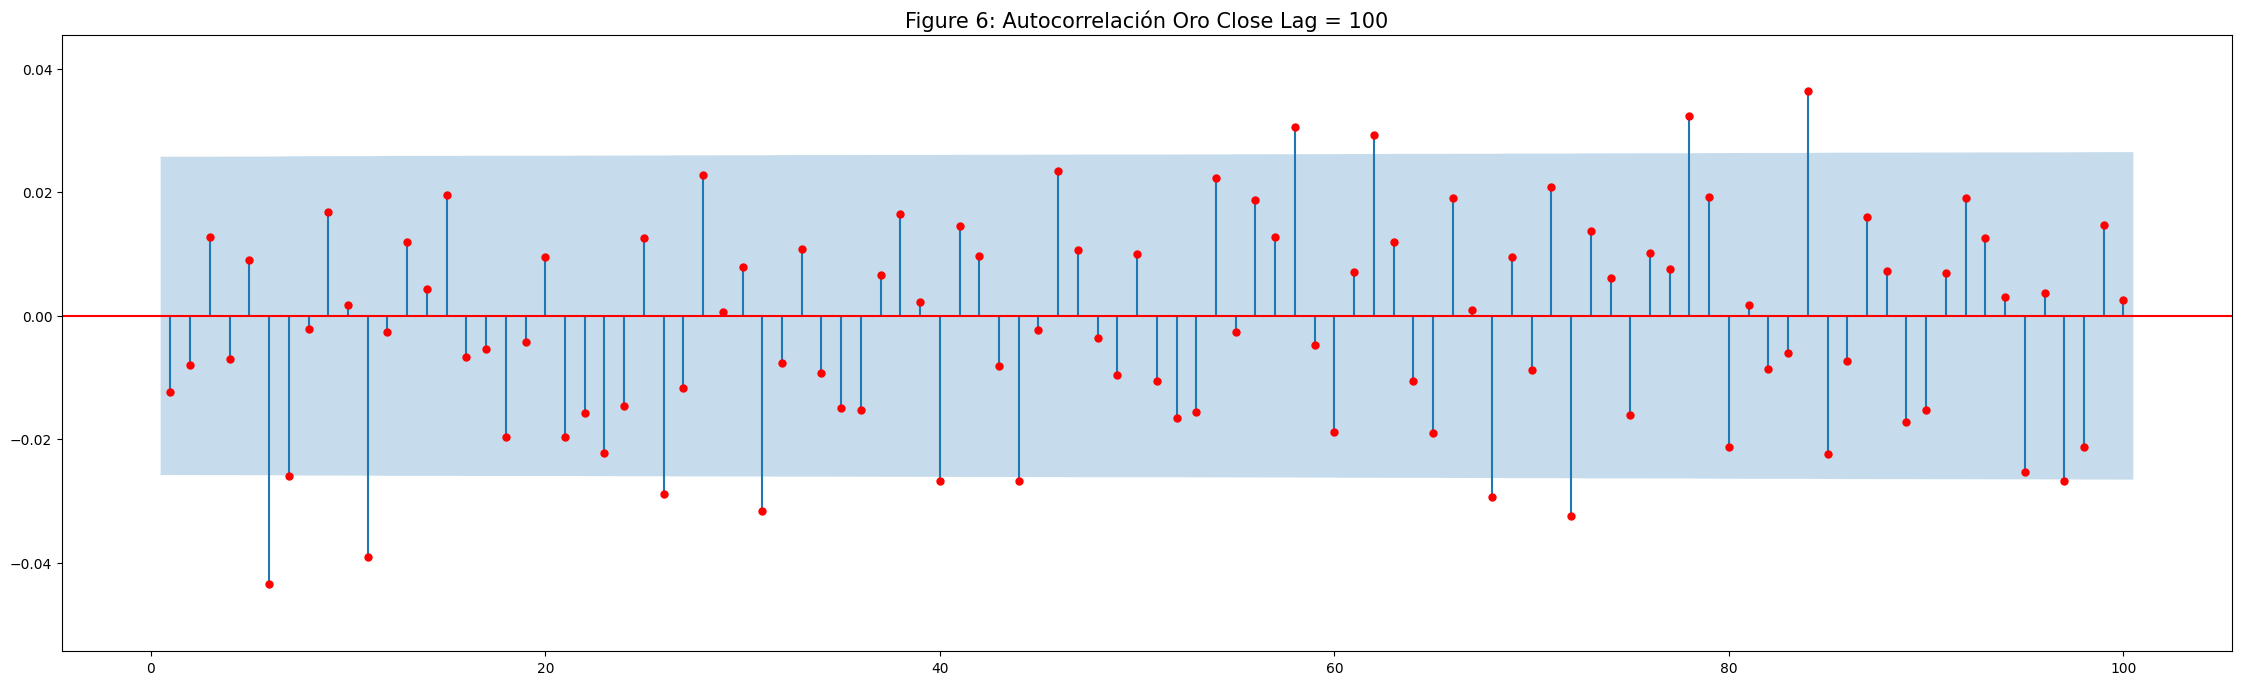

In [ ]:
curr_fig, curr_ax = plt.subplots(figsize=(28,8))
tsaplots.plot_acf(return_list(df['open']), lags=100, color='g', ax=curr_ax, zero = False, auto_ylims = True)
plt.title('Figure 5: Autocorrelación Oro Open Lag = 100', size = 15)
plt.show();

curr_fig, curr_ax = plt.subplots(figsize=(28,8))
tsaplots.plot_acf(return_list(df['close']), lags=100, color='r', ax=curr_ax, zero = False, auto_ylims = True)
plt.title('Figure 6: Autocorrelación Oro Close Lag = 100', size = 15)
plt.show()

In [ ]:
#Establecer como índice la fecha.
#df.set_index('date', inplace = True)

In [ ]:
print(wilcoxon(return_list(df['open']), zero_method = 'wilcox', correction = False))

WilcoxonResult(statistic=7634520.5, pvalue=6.20944286487464e-05)


In [ ]:
df[df['volume']==df['volume'].max()]

,date,open,high,low,close,volume
4446,2018-05-29,1298.699951,1298.699951,1298.699951,1298.699951,386334


In [ ]:
df.nlargest(10, 'volume')

,date,open,high,low,close,volume
4446,2018-05-29,1298.699951,1298.699951,1298.699951,1298.699951,386334
4824,2019-11-26,1459.800049,1459.800049,1459.800049,1459.800049,346362
4403,2018-03-27,1341.000000,1341.300049,1341.000000,1341.300049,290889
4363,2018-01-26,1351.599976,1352.000000,1350.900024,1351.599976,280546
3066,2012-11-28,1739.800049,1739.800049,1716.500000,1716.500000,276136
4323,2017-11-28,1294.699951,1294.699951,1294.699951,1294.699951,275442
4195,2017-05-26,1267.599976,1267.599976,1267.599976,1267.599976,271457
2940,2012-05-29,1574.699951,1582.500000,1548.599976,1548.599976,259050
4488,2018-07-27,1222.599976,1222.599976,1222.599976,1222.599976,254428
4866,2020-01-29,1569.800049,1569.800049,1569.800049,1569.800049,251274


## SEGUNDO NIVEL: Eficiencia Media

Para certificar el grado de eficiencia media de un mercado, hay que analizar la velocidad con la que asume la información que acaba de publicarse en los medios de comunicación.

Vamos a utilizar varias noticias

La primera de las buenas noticias, en fecha 26 de julio de 2019, es el anuncio del fin de el Acuerdo Central de Oro de los Bancos Centrales. Esto indica un periodo de madurez y estabilidad del oro, así como reafirma que los bancos centrales siguen siendo compradores netos y que el oro sigue actuando como una gran reserva de valor.
https://www.ecb.europa.eu/press/pr/date/2019/html/ecb.pr190726_1~3eaf64db9d.en.html
https://www.gold.org/official-institutions/central-bank-gold-agreement


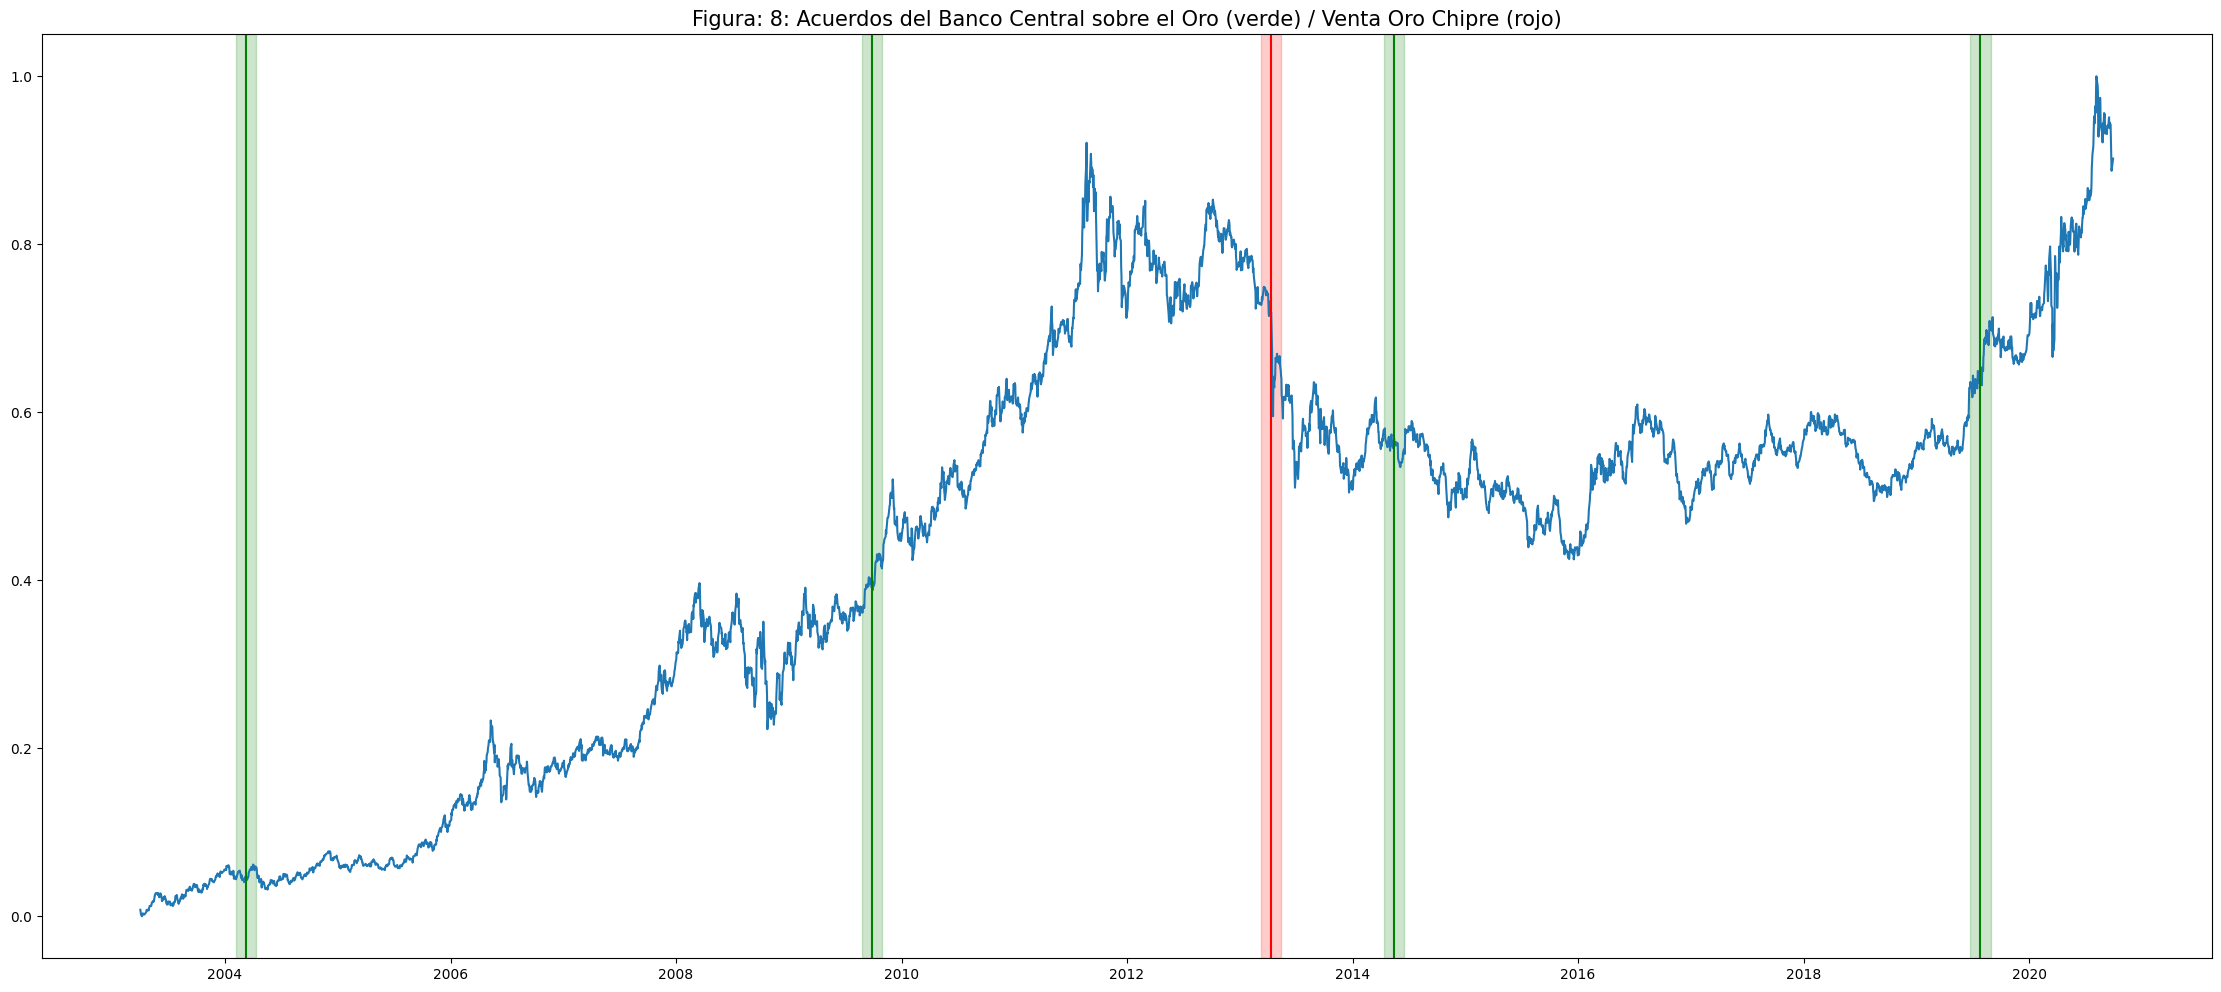

In [ ]:
df_2 = df[(df['date']>'2003-04-01') & (df['date']<'2020-09-30')].reset_index(drop = True)

plt.figure(figsize=(28,12))
plt.plot(df_2['date'], scale.fit_transform(df_2['open'].array.reshape(-1, 1)))
#Fin del acuerdo
plt.axvline(x = datetime(2019,7,26), color = 'g')
plt.axvspan(datetime(2019,6,23), datetime(2019,8,29), alpha=0.2, color='g')
#Inicio 2o Acuerdo
plt.axvline(x = datetime(2004,3,8), color = 'g')
plt.axvspan(datetime(2004,2,5), datetime(2004,4,11), alpha=0.2, color='g')
#Inicio 3er Acuerdo
plt.axvline(x = datetime(2009,9,27), color = 'g')
plt.axvspan(datetime(2009,8,25), datetime(2009,10,29), alpha=0.2, color='g')
#Inicio 4o acuerdo
plt.axvline(x = datetime(2014,5,14), color = 'g')
plt.axvspan(datetime(2014,4,11), datetime(2014,6,17), alpha=0.2, color='g')
#Cyprus sell-off fears send gold price tumbling
plt.axvline(x = datetime(2013,4,12), color = 'r')
plt.axvspan(datetime(2013,3,9), datetime(2013,5,13), alpha=0.2, color='r')
plt.title('Figura: 8: Acuerdos del Banco Central sobre el Oro (verde) / Venta Oro Chipre (rojo)', size = 15)
plt.show()






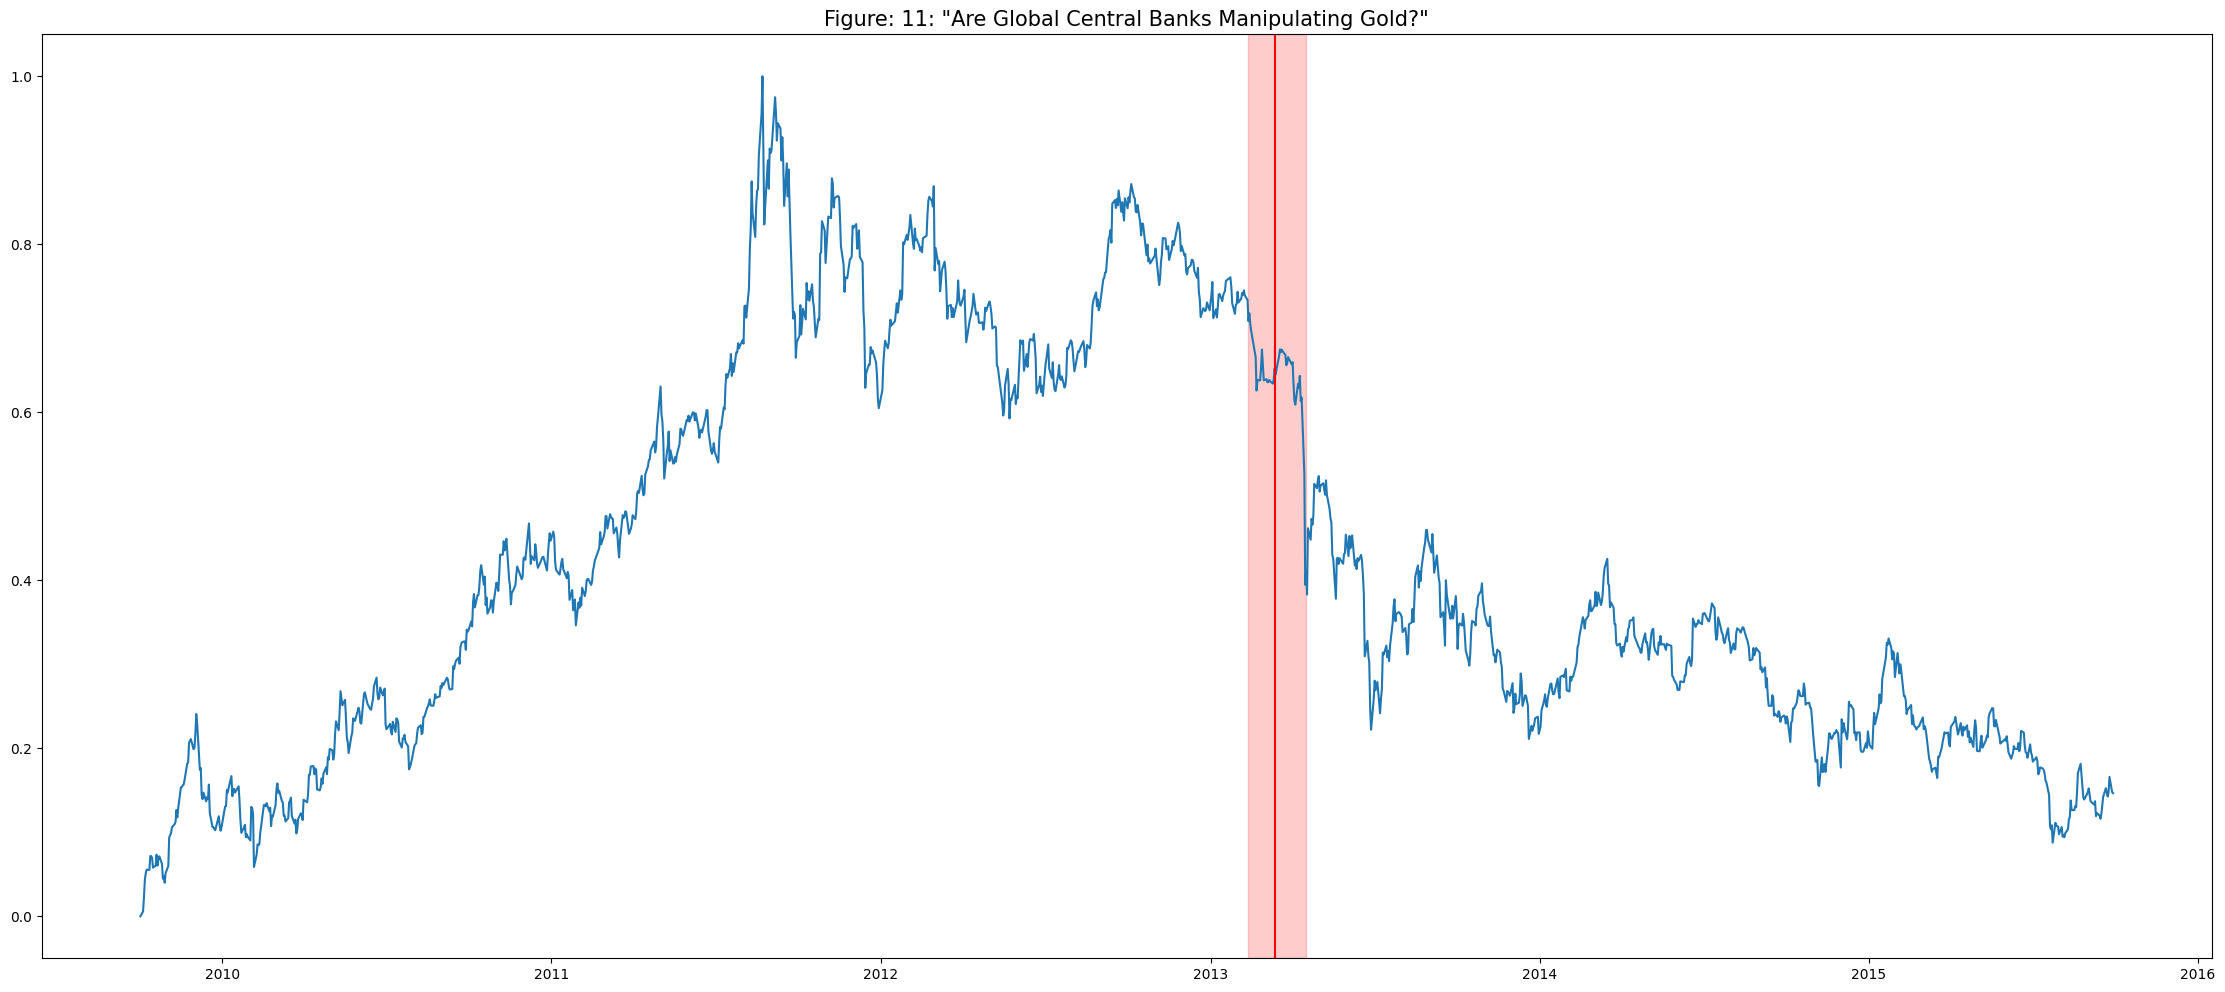

In [ ]:
df_marketManipulation = df[(df['date']>'2009-10-1') & (df['date']<'2015-09-30')].reset_index(drop = True)
plt.figure(figsize=(28,12))
plt.plot(df_marketManipulation['date'], scale.fit_transform(df_marketManipulation['open'].array.reshape(-1, 1)))
plt.axvline(x = datetime(2013,3,14), color = 'r')
plt.axvspan(datetime(2013,2,11), datetime(2013,4,17), alpha=0.2, color='r')
plt.title('Figure: 11: "Are Global Central Banks Manipulating Gold?"', size = 15)
plt.show()


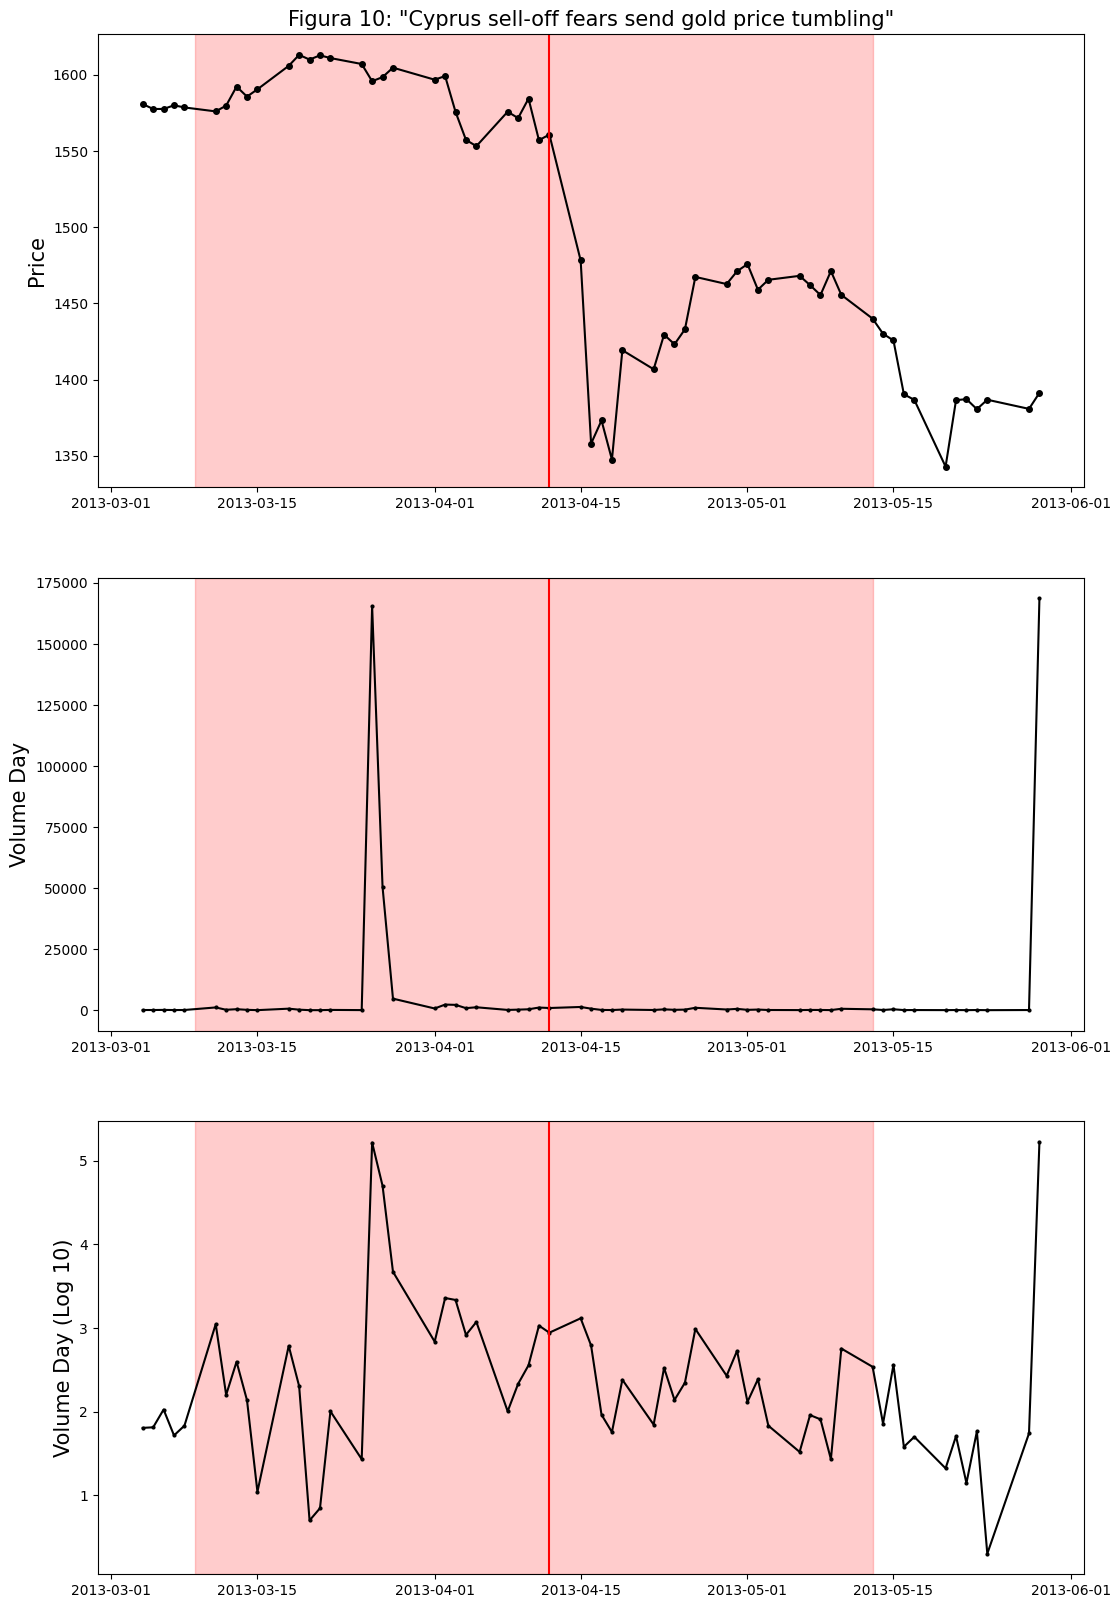

In [ ]:
#Oro Noticia negativa
df_day_30_neg = df[(df['date']>'2013-03-1') & (df['date']<'2013-05-30')].reset_index(drop = True)

plt.figure(figsize=(28,20))
plt.subplot(321)
plt.plot(df_day_30_neg['date'], df_day_30_neg['open'], 'ok-', markersize=4)
#Cyprus sell-off fears send gold price tumbling
plt.axvline(x = datetime(2013,4,12), color = 'r')
plt.axvspan(datetime(2013,3,9), datetime(2013,5,13), alpha=0.2, color='r')
plt.title('Figura 10: "Cyprus sell-off fears send gold price tumbling"', size = 15)
plt.ylabel('Price', size = 15)

plt.subplot(323)
plt.plot(df_day_30_neg['date'], df_day_30_neg['volume'], 'ok-', markersize=2)
#Cyprus sell-off fears send gold price tumbling
plt.axvline(x = datetime(2013,4,12), color = 'r')
plt.axvspan(datetime(2013,3,9), datetime(2013,5,13), alpha=0.2, color='r')

plt.ylabel('Volume Day', size = 15)


plt.subplot(325)
plt.plot(df_day_30_neg['date'], np.log10(df_day_30_neg['volume']), 'ok-', markersize=2)
#Cyprus sell-off fears send gold price tumbling
plt.axvline(x = datetime(2013,4,12), color = 'r')
plt.axvspan(datetime(2013,3,9), datetime(2013,5,13), alpha=0.2, color='r')

plt.ylabel('Volume Day (Log 10)', size = 15)
plt.show()

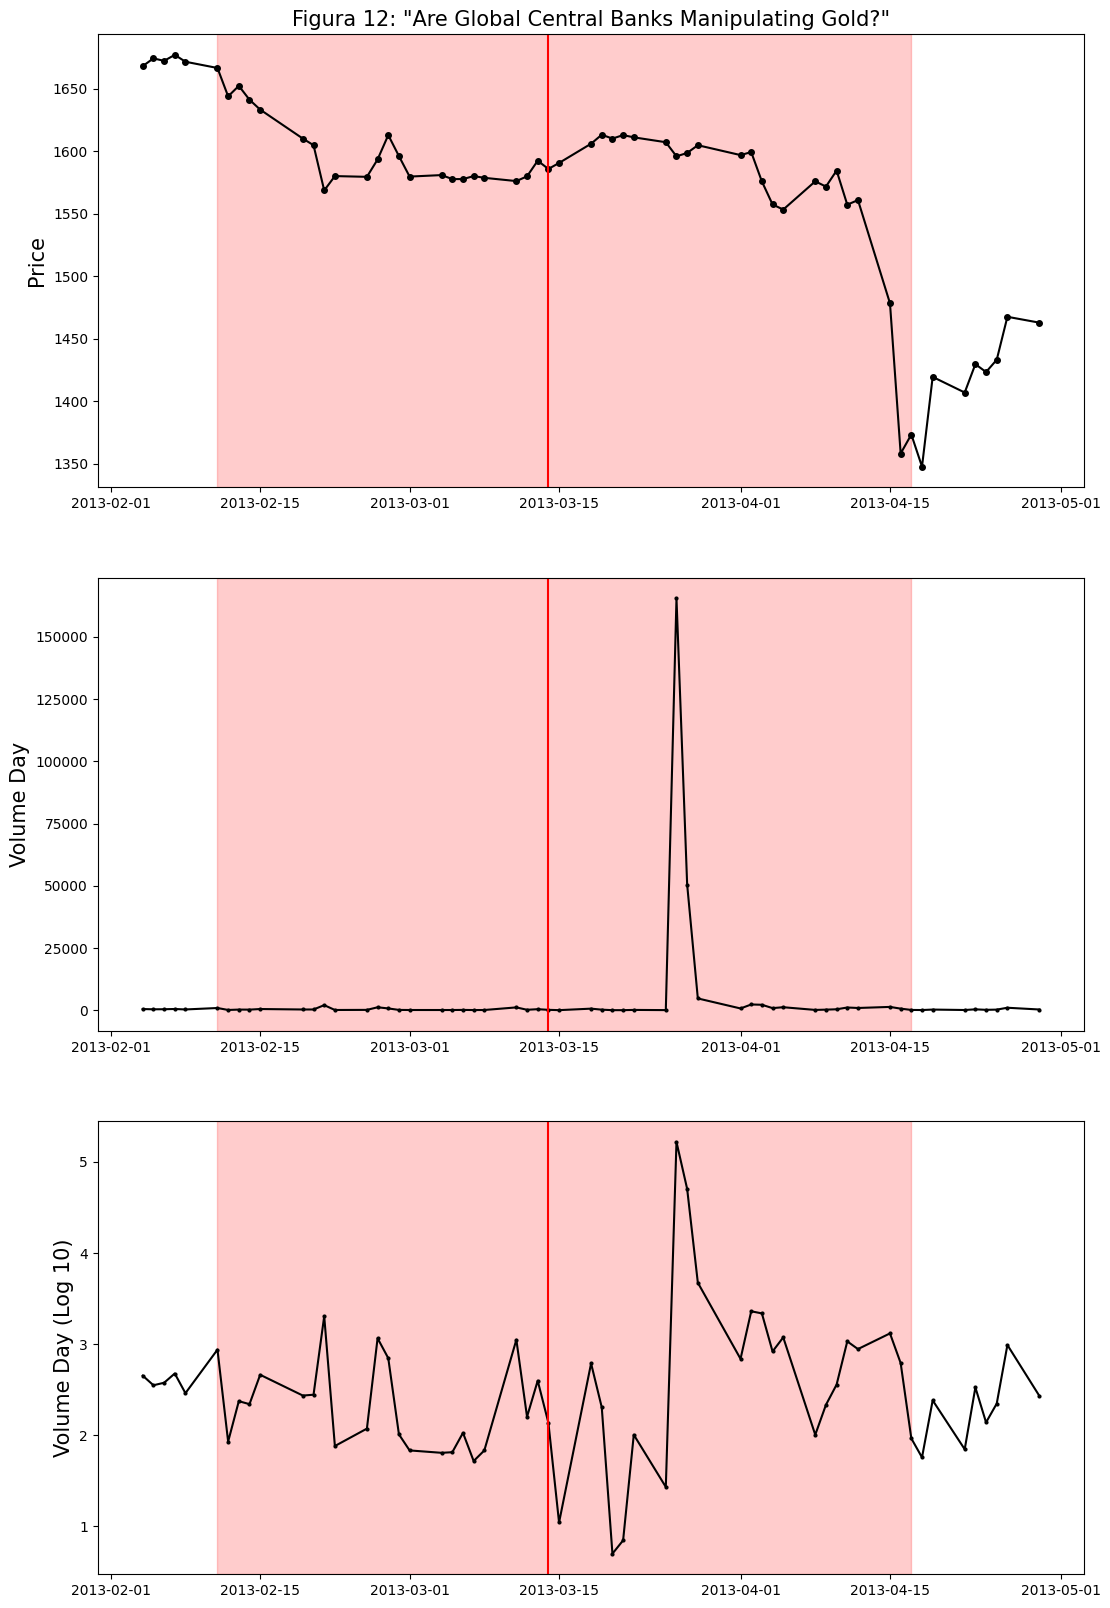

In [ ]:
#Oro Noticia negativa
df_day_30_neg = df[(df['date']>'2013-02-1') & (df['date']<'2013-04-30')].reset_index(drop = True)

plt.figure(figsize=(28,20))
plt.subplot(321)
plt.plot(df_day_30_neg['date'], df_day_30_neg['open'], 'ok-', markersize=4)
#Cyprus sell-off fears send gold price tumbling
plt.axvline(x = datetime(2013,3,14), color = 'r')
plt.axvspan(datetime(2013,2,11), datetime(2013,4,17), alpha=0.2, color='r')
plt.title('Figura 12: "Are Global Central Banks Manipulating Gold?"', size = 15)
plt.ylabel('Price', size = 15)

plt.subplot(323)
plt.plot(df_day_30_neg['date'], df_day_30_neg['volume'], 'ok-', markersize=2)
#Cyprus sell-off fears send gold price tumbling
plt.axvline(x = datetime(2013,3,14), color = 'r')
plt.axvspan(datetime(2013,2,11), datetime(2013,4,17), alpha=0.2, color='r')

plt.ylabel('Volume Day', size = 15)


plt.subplot(325)
plt.plot(df_day_30_neg['date'], np.log10(df_day_30_neg['volume']), 'ok-', markersize=2)
#Cyprus sell-off fears send gold price tumbling
plt.axvline(x = datetime(2013,3,14), color = 'r')
plt.axvspan(datetime(2013,2,11), datetime(2013,4,17), alpha=0.2, color='r')

plt.ylabel('Volume Day (Log 10)', size = 15)
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


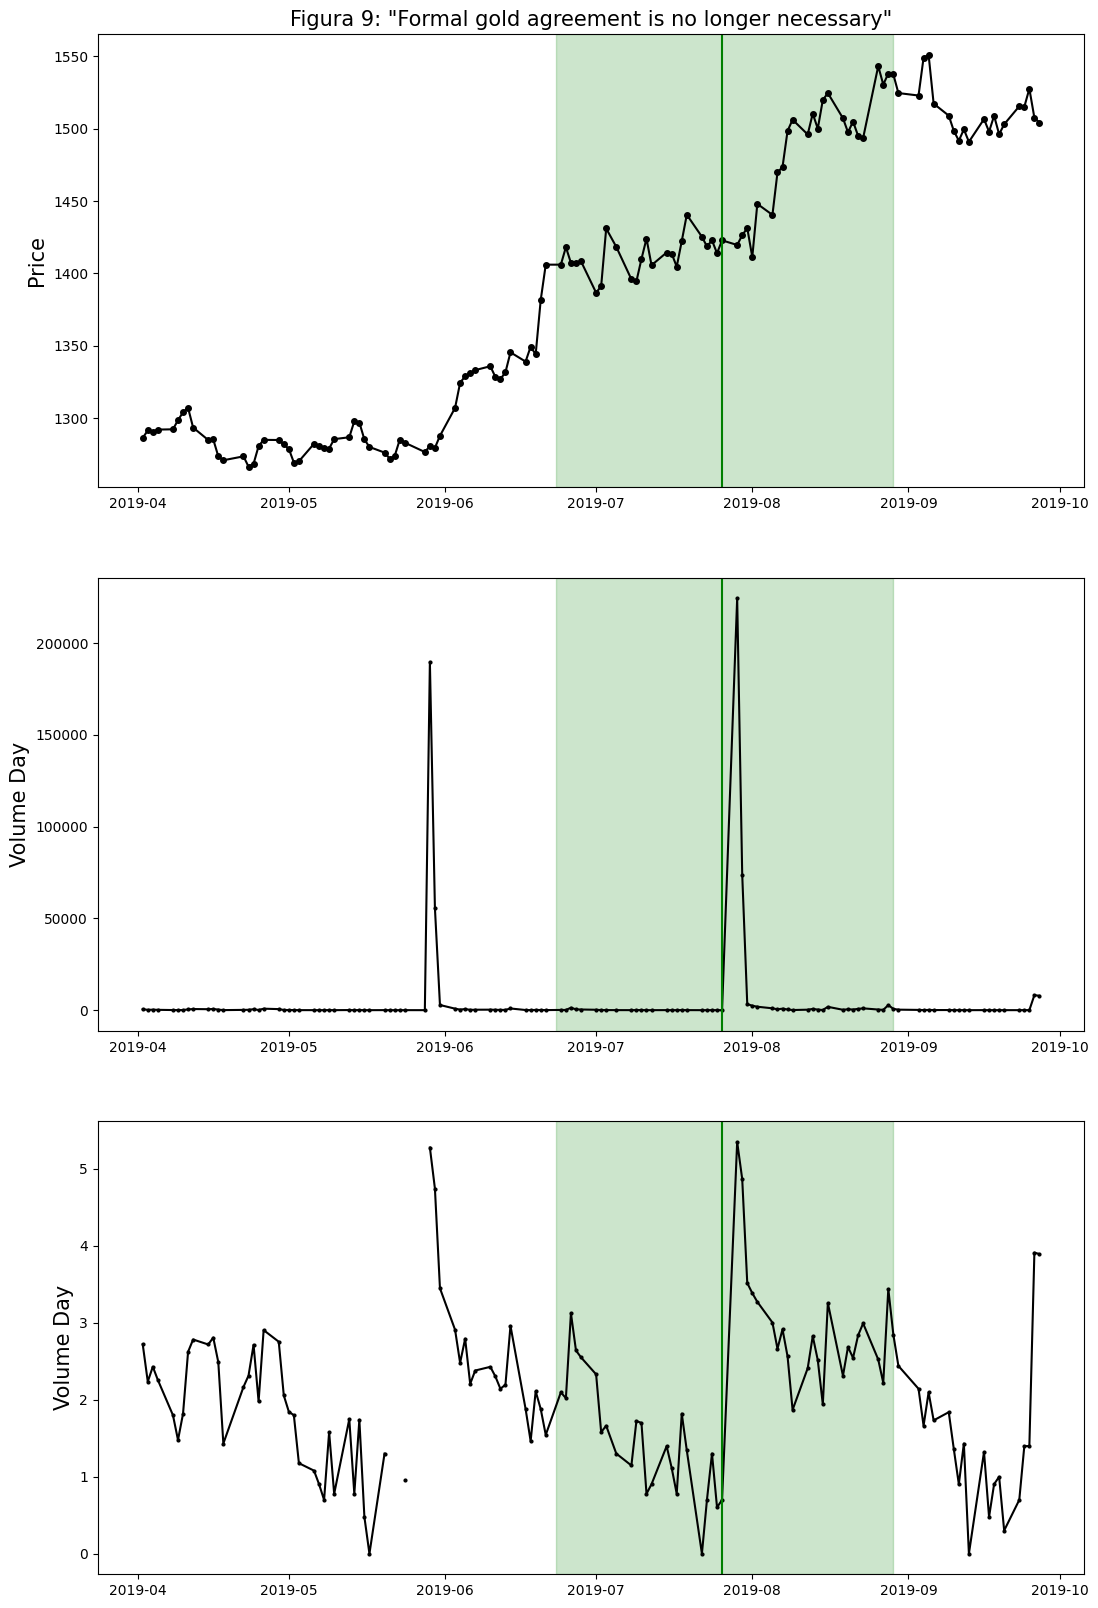

In [ ]:
df_day_30_pos = df[(df['date']>'2019-04-1') & (df['date']<'2019-09-30')].reset_index(drop = True)

plt.figure(figsize=(28,20))
plt.subplot(321)
plt.plot(df_day_30_pos['date'], df_day_30_pos['open'], 'ok-', markersize=4)
#Fin del acuerdo
plt.axvline(x = datetime(2019,7,26), color = 'g')
plt.axvspan(datetime(2019,6,23), datetime(2019,8,29), alpha=0.2, color='g')
plt.title('Figura 9: "Formal gold agreement is no longer necessary"', size = 15)
plt.ylabel('Price', size = 15)

plt.subplot(323)
plt.plot(df_day_30_pos['date'], df_day_30_pos['volume'], 'ok-', markersize=2)
#Fin del acuerdo
plt.axvline(x = datetime(2019,7,26), color = 'g')
plt.axvspan(datetime(2019,6,23), datetime(2019,8,29), alpha=0.2, color='g')

plt.ylabel('Volume Day', size = 15)


plt.subplot(325)
plt.plot(df_day_30_pos['date'], np.log10(df_day_30_pos['volume']), 'ok-', markersize=2)
#Fin del acuerdo
plt.axvline(x = datetime(2019,7,26), color = 'g')
plt.axvspan(datetime(2019,6,23), datetime(2019,8,29), alpha=0.2, color='g')

plt.ylabel('Volume Day', size = 15)
plt.show()


In [ ]:
df.query("date == '2008-09-02'")

,date,open,high,low,close,volume
1998,2008-09-02,829.900024,840.700012,790.799988,805.0,185


### Noticias sobre inflación y crisis

Dado el carácter que tiene el oro como reserva de valor, nos gustaría comprobar la capacidad que tiene de adaptarse a periodos inestables como las crisis del 2008 y del Covid-19, así como a periodos de inflación que provocan que el precio de oro aumente para protegerse de la devaluación de la moneda.

Los periodos de crisis escogidos son los siguientes:

-  Crisis de 2008, hemos tomado como referencia el 15 de septiembre de 2008, día en que quiebra Lehman Brothers y en el que la bolsa de Nueva York tuvo el mayor desplome histórico en un solo día. https://elpais.com/economia/2008/09/15/actualidad/1221463973_850215.html

- Crisis de 2020: Causado por el Covid-19, tomamos como referencia el 10 de marzo de 2020, día en el que Italia anunció la cuarentena y dio la voz de alarma en el mundo. https://edition.cnn.com/2020/03/10/world/coronavirus-covid-19-update-intl-hnk/index.html


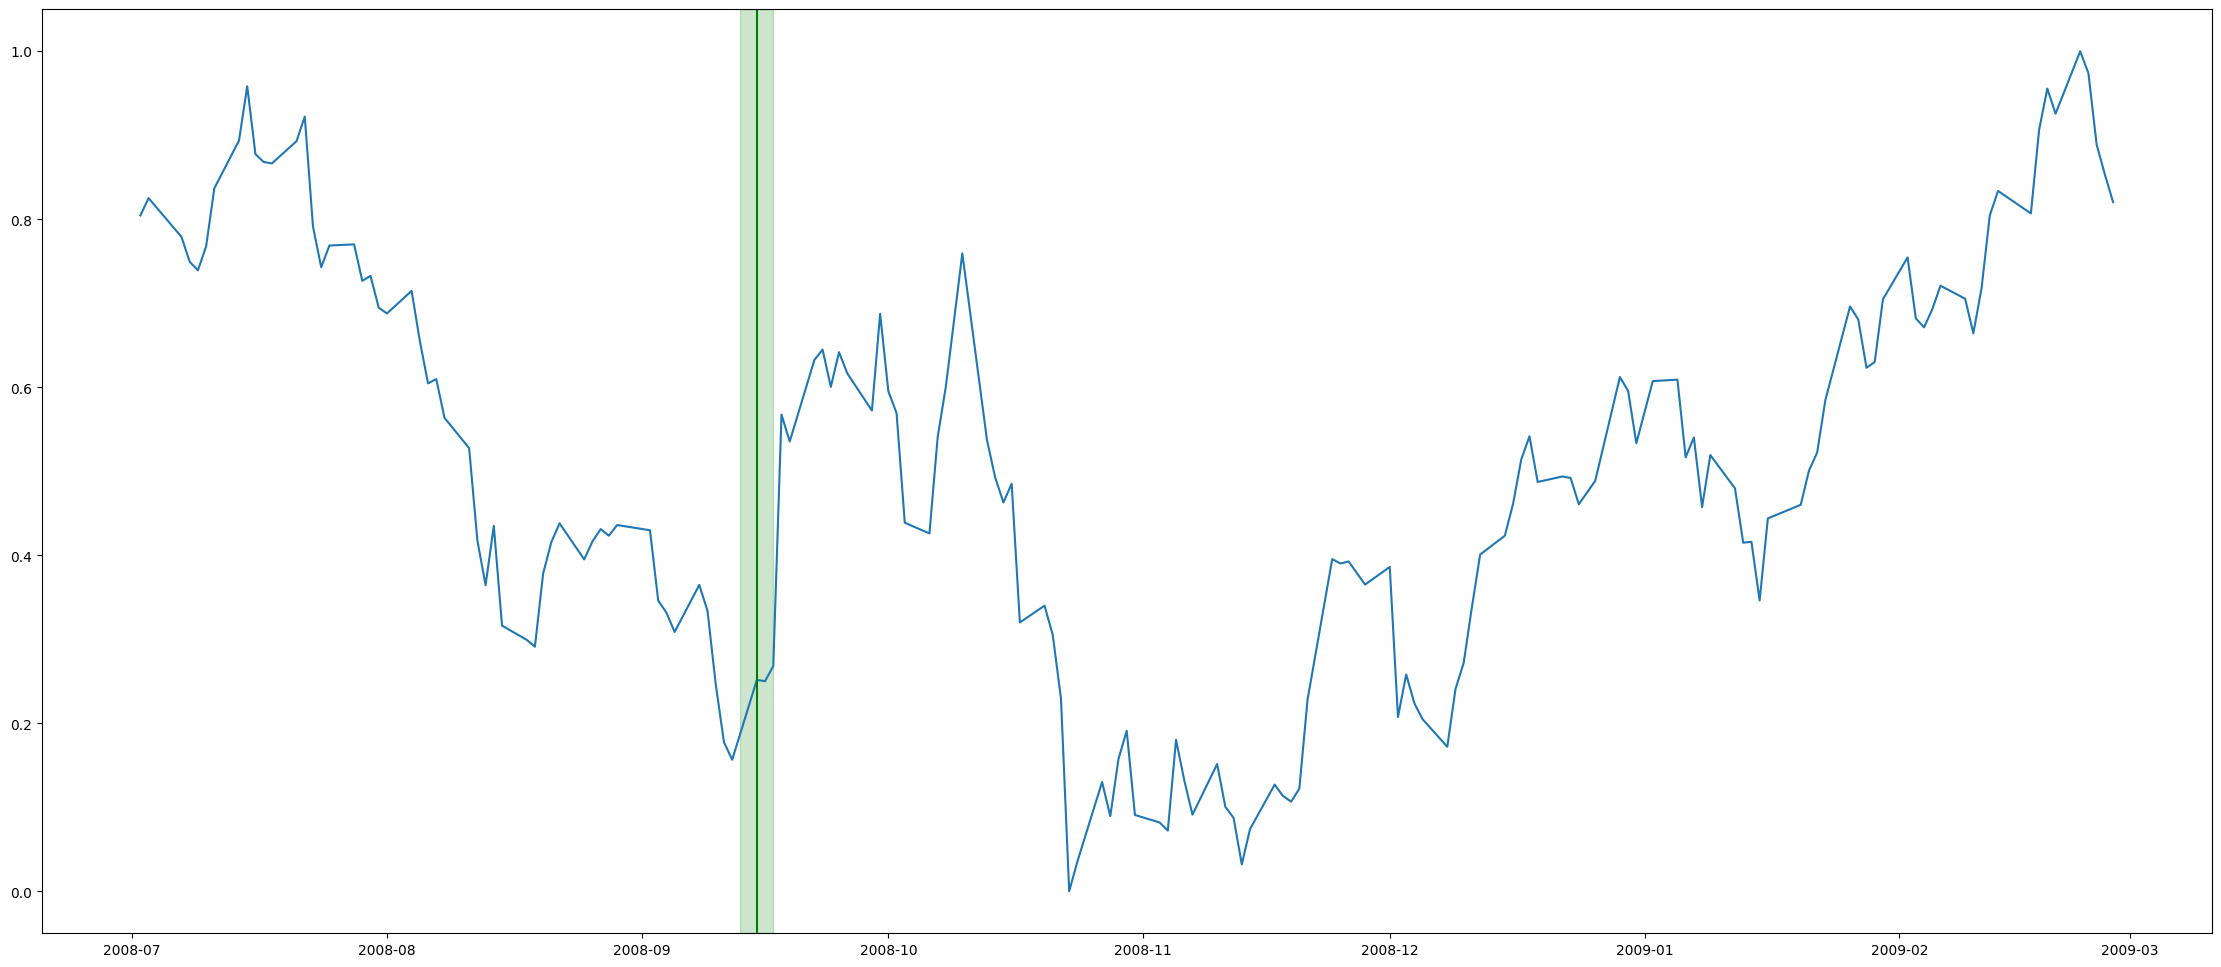

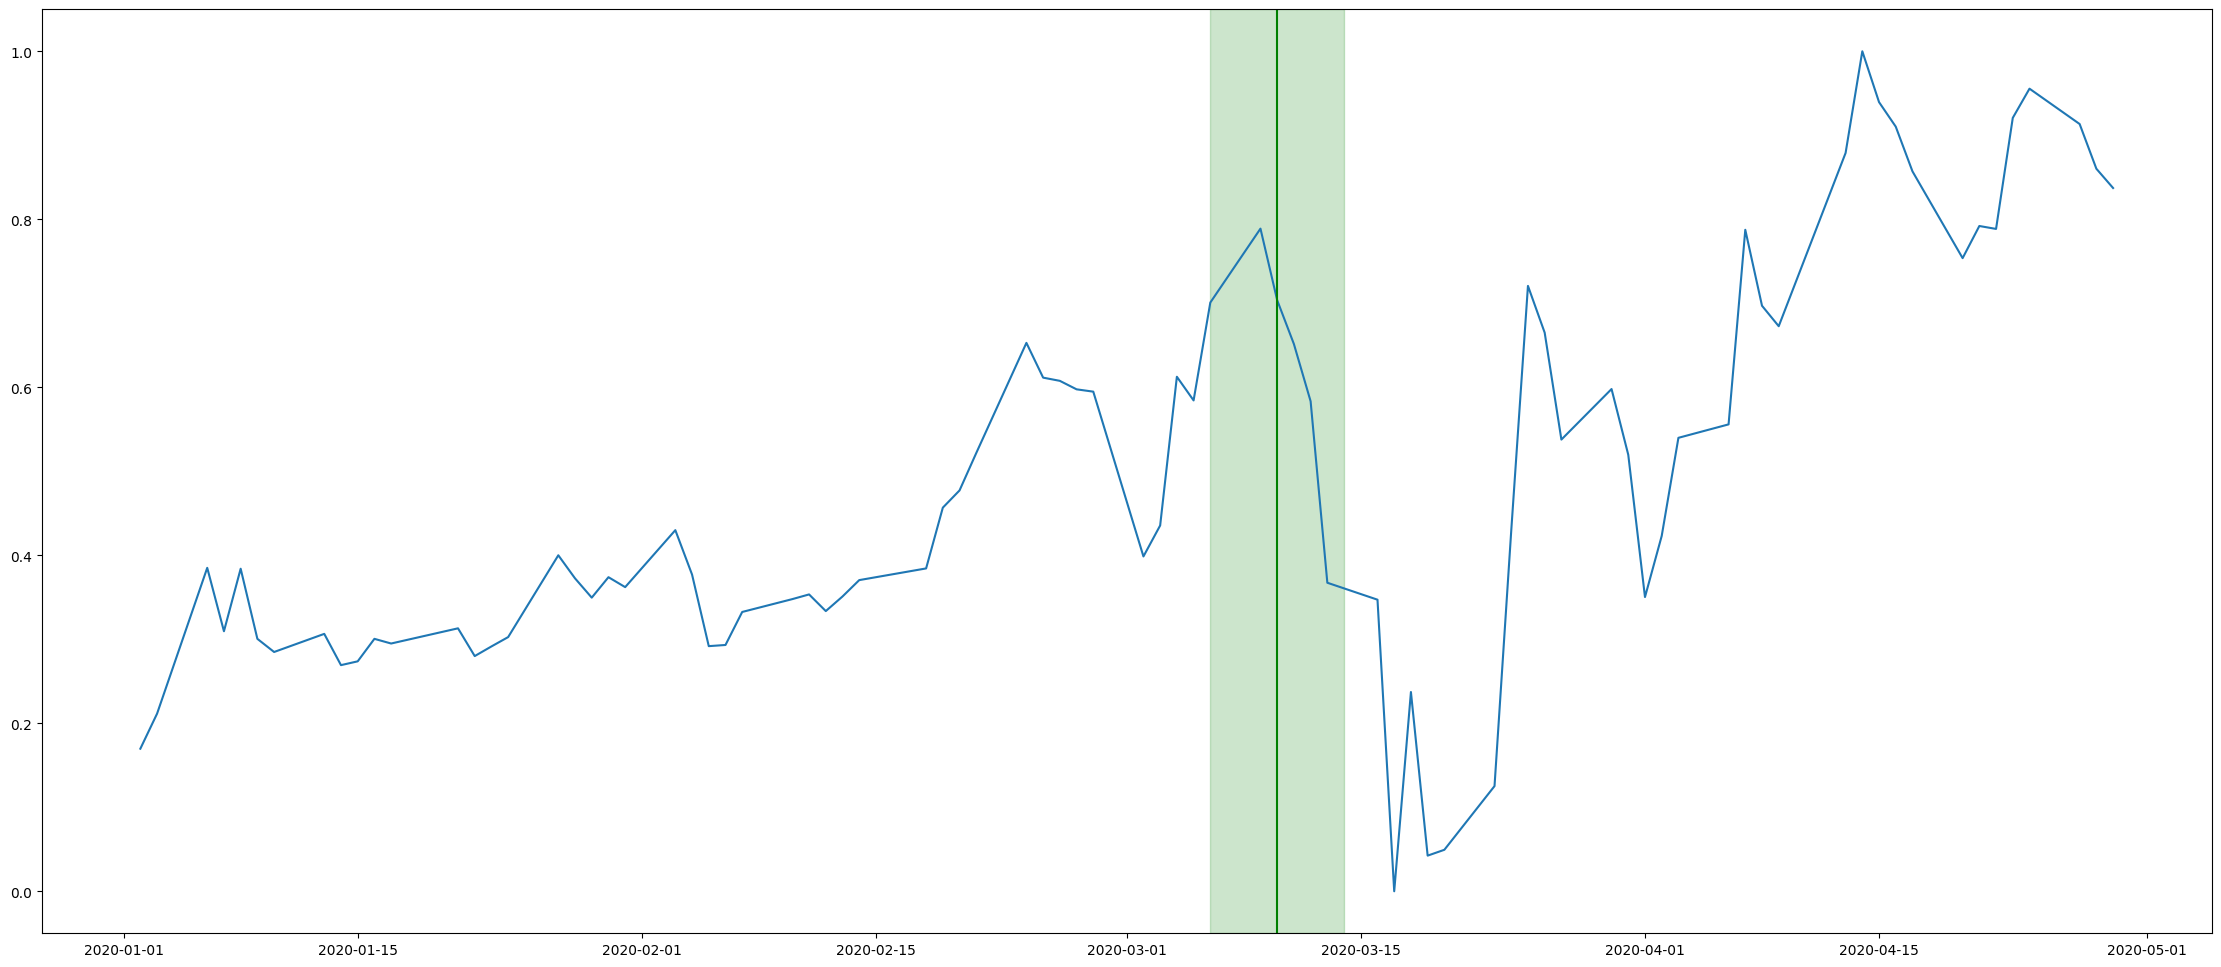

In [ ]:
df_2 = df[(df['date']>'2008-07-01') & (df['date']<'2009-02-28')].reset_index(drop = True)

plt.figure(figsize=(28,12))
plt.plot(df_2['date'], scale.fit_transform(df_2['open'].array.reshape(-1, 1)))
plt.axvline(x = datetime(2008,9,15), color = 'g')
plt.axvspan(datetime(2008,9,13), datetime(2008,9,17), alpha=0.2, color='g')
plt.show()

df_3 = df[(df['date']>'2020-01-01') & (df['date']<'2020-04-30')].reset_index(drop = True)

plt.figure(figsize=(28,12))
plt.plot(df_3['date'], scale.fit_transform(df_3['open'].array.reshape(-1, 1)))
plt.axvline(x = datetime(2020,3,10), color = 'g')
plt.axvspan(datetime(2020,3,6), datetime(2020,3,14), alpha=0.2, color='g')
plt.show()